# Process the data
Experiment with Aarhus (2020):
- 18 keV
- pixel = 6.5/40 um
- distances: 135, 140, 144, 152


**Comments**:
<br>
some problems with the data collection for distances 140 and 144 mm.
- In the case of 140mm, the images of section 79 were not recorded – this dataset includes one additional section (120) which was probably recorded to replace 79 but they are not at the same position. Section 79 is part of the sample while section 120 is outside of the sample. That is clear when using images 120 in the position of section 79.
- For 144mm, the images of section 55 were not recorded in between 201.8 and 360 degrees (except for 201.9). This is why I was getting an error when running the stitching function for some slices at distance 144mm – these slices only have 118 images, as opposed to 119.

In [1]:
import numpy as np
from maximus48 import SSIM_131119 as SSIM
from maximus48 import var
import tifffile
import matplotlib.pyplot as plt
import os

## Read all paths

In [2]:
folder = '/mnt/beegfs/P14/2020/p3l-gleb1/20201129/RAW_DATA/imaging/'
#folder = '/Users/au704469/Documents/Postdoc/Results/X-ray_tomography/Brain_organoid_P14_DESY_Nov2020/Data_test/'+distance+'mm/'

In [3]:
#create the list all images in the folder
imlist = os.listdir(folder)

## Open one projection for tests

In [4]:
distance = '135mm'
image = '00001.tiff'

In [5]:
# select just one distance and one acquisition/projection
def find_paths_single_distance_all(data_list, key, distance, image):
    return [i for i in data_list if (i.startswith(key) and distance in i and image in i)]

In [6]:
# this is also very ugly way of sorting
def find_counter(string, start, end):
    return (string.split(start))[1].split(end)[0]

In [7]:
def find_ffs_simple(data_list, key):
    """
    Just for one image
    data_list: all data in the folder
    key: name of the file for which ff-s should be found
    """
    outs = [i for i in data_list if i.startswith('ff_'+key)]
    outs.sort()
    return outs

def find_ffs_list(data_list, image_list):
    """
    For a list of images
    data_list: all data in the folder
    image_list: list of images for which you want to find ff-s
    key: name of the file for which ff-s should be found
    """
    all_ff=[]
    for i in image_list:
        one_ff = []
        key = i[:-10]
        one_ff.append(find_ffs_simple(imlist, key))
        all_ff.append(one_ff)
        
    return all_ff

In [8]:
data_test = find_paths_single_distance_all(imlist, key ='try0', distance = distance, image = image)
data_test = sorted(data_test, key=lambda i: int(find_counter(i, start = distance + "_", end = "_"+image)))

In [9]:
ff_test = find_ffs_list(imlist, image_list = data_test)

## Do ff-correction
load the pre-processed data simply

In [11]:
path_to_save = '/mx-beta/anaconda3/mpolikarpov_scripts/2021_Aarhus/test_data/'

In [18]:
# load the data
ff_corrected = np.load(path_to_save+'test_projection_135mm_0001.npy')

## Stitching - try here

### find auto-find shift between two images (horizontally)

In [19]:
# calculate shift of the image between the i-th and the 1-st distance
from maximus48 import multiCTF2 as multiCTF

motor_step_mm = 0.25*1e-3
pixel_size = 6.5/40 *1e-6
motor_step_pix = motor_step_mm/pixel_size 

image_size = 2048 - 100
crop_area = image_size - int(motor_step_pix)

In [20]:
#### select images here
Image_number = 9
Image_row = 3

i = Image_number + Image_row*17

[ 3.45 11.18]


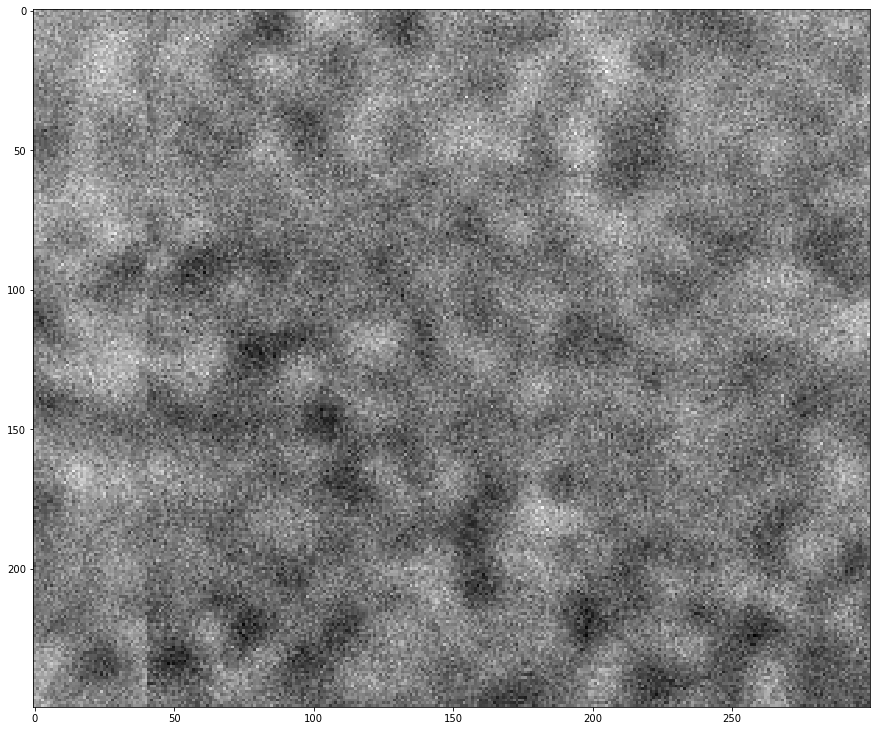

In [21]:
# probably don't touch anything here
image1 = ff_corrected[i]
image2 = ff_corrected[i-1]

# find shift
pre_cut = 1500
shift = multiCTF.shift_distance(image1[:,pre_cut:],
                                image2[:,:2048-100-pre_cut], 100)
print(shift)
# note that here you can play with Region Of Interest for the pre-cut. 
# For instance, changing pre-cut will increase or decrease the ROI for comparison of shifts


# test stiching - horizontal direction
cropme = np.s_[:,:int(motor_step_pix)+int(shift[0])]
# note that you shift the image with this last part (..shift(0)), in horizontal direction only


# you can also do it manually below (uncomment)
# cropme = np.s_[:,:int(motor_step_pix)-11]


# combine an image and show
test = np.concatenate([image1[cropme], image2[cropme]], axis = 1)
plt.figure(figsize = (15,15))

# you can change ROI of what you will see below
ROI_to_show = np.s_[1500:1750,1500:1800]
ROI_to_show = np.s_[1500:1750,1500:1800]
plt.imshow(test[ROI_to_show], cmap = 'gray')

TODO:
- play with different image numbers in a row (cell 20)
- play with different rows (cell 20)
- play with ROI, see how it affects the result (shift)
- inspect images visually (above) and try to conclude if the stiching was succesful

we need to find some pattern of shifts or behaviour to make stiching in the horizontal direction. 